In [1]:
pip install tldextract

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 1.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
import re
import tldextract
from urllib.parse import urlparse
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS
from nltk.tokenize import RegexpTokenizer # regexp tokenizers use to split words from text
from nltk.stem.snowball import SnowballStemmer # stemmes words
import time # calculate time

#Garbage
import gc

#Warnings
import warnings
warnings.filterwarnings("ignore")

#SKLearn Libraries

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.ensemble import StackingClassifier
from scipy.sparse import hstack
import scipy.sparse

#WordCloud Generator
from wordcloud import WordCloud,STOPWORDS

#Plotting Library
import matplotlib.pyplot as plt
import seaborn as sns

# Telechargement des données

In [3]:
df=pd.read_csv('/content/dataset.csv')

In [ ]:
df.head()

,domain,label
0,http://sprint.com/business/solutions/mobility_...,0.0
1,hesperia.gsfc.nasa.gov/~schmahl/nnls/,0.0
2,http://web.de/magazine/digital/sicher-im-netz/...,0.0
3,www.wired.com/science/discoveries/news/1999/08...,0.0
4,thomas.arnatt.com/wp-includes/pono/AOL_Logio.htm,1.0


In [ ]:
df.columns

Index(['domain', 'label'], dtype='object')

In [ ]:
len(df)

120990

# Pretraitement des données

In [4]:
# Fonction de nettoyage des données
def clean_data(df):
    # Supprimer les doublons Suppression des doublons dans un ensemble de données.
    # Les doublons sont un cas extrême d'échantillonnage non aléatoire et ils peuvent fausser le modèle ajusté.
    # Les inclure conduira essentiellement à un surajustement du modèle pour ce sous-ensemble de points.
    df = df.drop_duplicates()

    return df.dropna() # Suppression des lignes avec des valeurs manquantes

In [5]:
# Fonction de tokenisation, découper les URL en tokens (segments) pour extraire des caractéristiques textuelles
def tokenize_url(df):
    df['domain'] = df['domain'].str.lower()
    tokenizer = RegexpTokenizer(r'[A-Za-z]+')
    df['text_tokenized'] = df.domain.map(lambda t: tokenizer.tokenize(t)) # doing with all rows
    return df

In [6]:
def sentence_transfo(df):
  #Snowball est un petit langage de traitement des chaînes de caractères, qui donne des mots racines.
  #Dans ce cas, j'ai choisi l'anglais comme langue car les urls sont en anglais.
  stemmer = SnowballStemmer("english")

  df['text_stemmed'] = df['text_tokenized'].map(lambda l: [stemmer.stem(word) for word in l])
  df['text_sent'] = df['text_stemmed'].map(lambda l: ' '.join(l))

  return df

In [7]:
# Extraction des composants de l'URL
def extract_url_features(df):
    # Ajouter le schéma (http) si l'URL n'en a pas
    df['domain'] = df['domain'].apply(lambda x: "http://" + x if not x.startswith(("http://", "https://")) else x)

    # Extraire les composants de l'URL
    df['parsed_url'] = df['domain'].apply(lambda x: urlparse(x))
    df['domain_main'] = df['parsed_url'].apply(lambda x: x.netloc)
    df['path'] = df['parsed_url'].apply(lambda x: x.path)
    df['query'] = df['parsed_url'].apply(lambda x: x.query)
    df['query'] = df['query'].replace('','None')
    df["tld"] = df.domain_main.apply(lambda nl: tldextract.extract(nl).suffix)
    df['tld'] = df['tld'].replace('','None')

    """
    Les sections suivantes concernent certaines ponctuations dans l'URL qui peuvent indiquer d'une manière ou d'une autre qu'une
    URL est malveillante. Mon raisonnement est le suivant : les domaines typosquattés (qui sont presque toujours malveillants) peuvent
    contenir cette ponctuation pour ressembler à un domaine légitime. Il peut également y avoir plus de ces ponctuations dans le chemin
    de l'URL pour une URL légitime, car les blogs utilisent souvent des underscores dans une URL.
    """

    # Longueur de l'URL
    df['url_length'] = df['domain'].apply(lambda x: len(x))

    # Nombre de sous-domaines
    df['num_subdomains'] = df['domain_main'].apply(lambda x: len(x.split('.')) - 2)

    # Nombre de paramètres dans la query
    df['num_params'] = df['query'].apply(lambda x: len(x.split('&')) if x else 0)

    df['path_hyphens'] = df.path.str.count('-')
    df['path_underscores'] = df.path.str.count('_')
    df['slashes'] = df.path.str.count('/')

    """
    Les points dans le chemin d'accès peuvent indiquer une tentative de tromper l'utilisateur en lui faisant croire que le domaine est
    légitime. Par exemple, example.com/bankofamerica.com peut induire en erreur. De plus, les points peuvent signaler la présence de
    fichiers malveillants, comme malware.exe, dans l'URL.
    """
    df['full_stops'] = df.path.str.count('.')

    # Fréquence des caractères spéciaux
    df['num_special_chars'] = df['domain'].apply(lambda x: len(re.findall(r'[\W_]', x)))

    return df

In [8]:
def preprocess(df):
  df1 = clean_data(df)
  df2 = tokenize_url(df1)
  df3 = sentence_transfo(df2)
  df4 = extract_url_features(df3)

  # Sauvegarder le DataFrame prétraité
  df4.to_csv('preprocessed_data.csv', index=False)
  return df4

In [9]:
preprocessed_data = preprocess(df)

In [43]:
preprocessed_data.head()

,domain,label,text_tokenized,text_stemmed,text_sent,parsed_url,domain_main,path,query,tld,url_length,num_subdomains,num_params,path_hyphens,path_underscores,slashes,full_stops,num_special_chars
0,http://sprint.com/business/solutions/mobility_...,0.0,"['http', 'sprint', 'com', 'business', 'solutio...","['http', 'sprint', 'com', 'busi', 'solut', 'mo...",http sprint com busi solut mobil secur and man...,"ParseResult(scheme='http', netloc='sprint.com'...",sprint.com,/business/solutions/mobility_security_and_mana...,intnav=atg:he:mobsecmgmt,com,105,0,1,0,3,4,63,16
1,http://hesperia.gsfc.nasa.gov/~schmahl/nnls/,0.0,"['hesperia', 'gsfc', 'nasa', 'gov', 'schmahl',...","['hesperia', 'gsfc', 'nasa', 'gov', 'schmahl',...",hesperia gsfc nasa gov schmahl nnls,"ParseResult(scheme='http', netloc='hesperia.gs...",hesperia.gsfc.nasa.gov,/~schmahl/nnls/,,gov,44,2,1,0,0,3,15,10
2,http://web.de/magazine/digital/sicher-im-netz/...,0.0,"['http', 'web', 'de', 'magazine', 'digital', '...","['http', 'web', 'de', 'magazin', 'digit', 'sic...",http web de magazin digit sicher im netz siche...,"ParseResult(scheme='http', netloc='web.de', pa...",web.de,/magazine/digital/sicher-im-netz/sicherheitshi...,,de,131,0,1,10,0,4,118,18
3,http://www.wired.com/science/discoveries/news/...,0.0,"['www', 'wired', 'com', 'science', 'discoverie...","['www', 'wire', 'com', 'scienc', 'discoveri', ...",www wire com scienc discoveri news,"ParseResult(scheme='http', netloc='www.wired.c...",www.wired.com,/science/discoveries/news/1999/08/21495,,com,59,1,1,0,0,6,39,11
4,http://thomas.arnatt.com/wp-includes/pono/aol_...,1.0,"['thomas', 'arnatt', 'com', 'wp', 'includes', ...","['thoma', 'arnatt', 'com', 'wp', 'includ', 'po...",thoma arnatt com wp includ pono aol logio htm,"ParseResult(scheme='http', netloc='thomas.arna...",thomas.arnatt.com,/wp-includes/pono/aol_logio.htm,,com,55,1,1,1,1,3,31,11


# Data Viz

In [44]:
def plot_label_distribution(df, label_column, title="Distribution des Labels"):
    """
    Fonction pour visualiser la distribution des labels dans un DataFrame.

    :param df: DataFrame contenant les données.
    :param label_column: Nom de la colonne contenant les labels.
    :param title: Titre du graphique.
    """
    # Mapping des valeurs de label
    df['label_renamed'] = df[label_column].map({0.0: 'Légitime', 1.0: 'Phishing'})

    # Création du graphique
    plt.figure(figsize=(8, 6))
    sns.countplot(x="label_renamed", data=df, palette=["#5cb85c", "#d9534f"])

    # Ajouter un titre et des labels
    plt.title(title, fontsize=16)
    plt.xlabel("Type de Label", fontsize=14)
    plt.ylabel("Nombre d'échantillons", fontsize=14)

    # Afficher les valeurs au-dessus des barres
    for p in plt.gca().patches:
        plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    # Afficher le graphique
    plt.show()

# Exemple d'utilisation
# plot_label_distribution(df, "label")


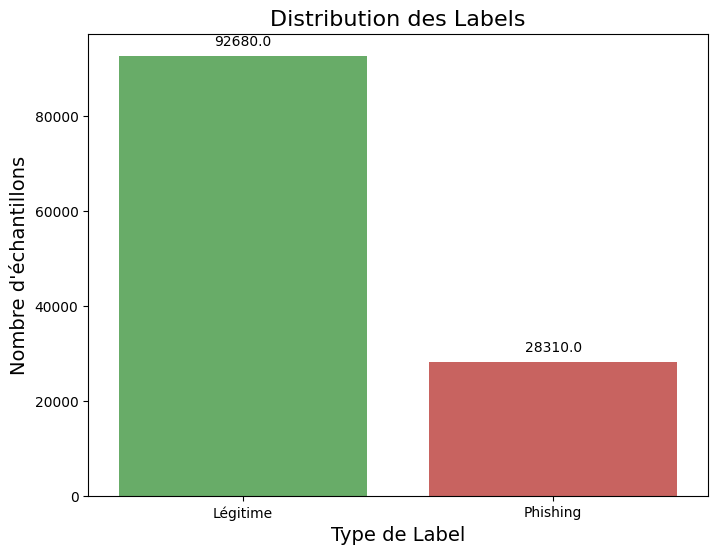

In [ ]:
plot_label_distribution(preprocessed_data, 'label', title="Distribution des Labels")

La distribution des labels montre un déséquilibre marqué entre les URL légitimes et les URL de phishing. La barre verte représente les URL légitimes avec un nombre d'échantillons de 92,680, tandis que la barre rouge représente les URL de phishing avec un nombre d'échantillons de 28,310. Cela indique que la majorité des URL dans le dataset sont légitimes, et les URL de phishing sont en nombre nettement inférieur.

L'analyse de ces résultats met en évidence un déséquilibre significatif des classes dans le dataset. Ce déséquilibre peut potentiellement biaiser les modèles de classification, les rendant plus enclins à prédire qu'une URL est légitime plutôt que de phishing. Cela pose un défi particulier car les URL de phishing, bien que moins nombreuses, sont souvent celles qui nécessitent une détection plus précise et rigoureuse.

Pour gérer ce déséquilibre, je vais utiliser la techniques de rééquilibrage des classe, SMOTE (Synthetic Minority Over-sampling Technique), qui permet de générer des échantillons synthétiques pour la classe minoritaire, dans ce cas, les URL de phishing.

In [ ]:
def plot_wordcloud(text, mask=None, max_words=400, max_font_size=120, figure_size=(24.0,16.0),
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'com','http'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size,
                    random_state = 42,
                    mask = mask)
    wordcloud.generate(text)

    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'green',
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

In [ ]:
df_Bad = preprocessed_data[preprocessed_data['label']==1.0].sample(frac=0.1, replace=True, random_state=1)
df_Good = preprocessed_data[preprocessed_data['label']==0.0].sample(frac=0.1, replace=True, random_state=1)

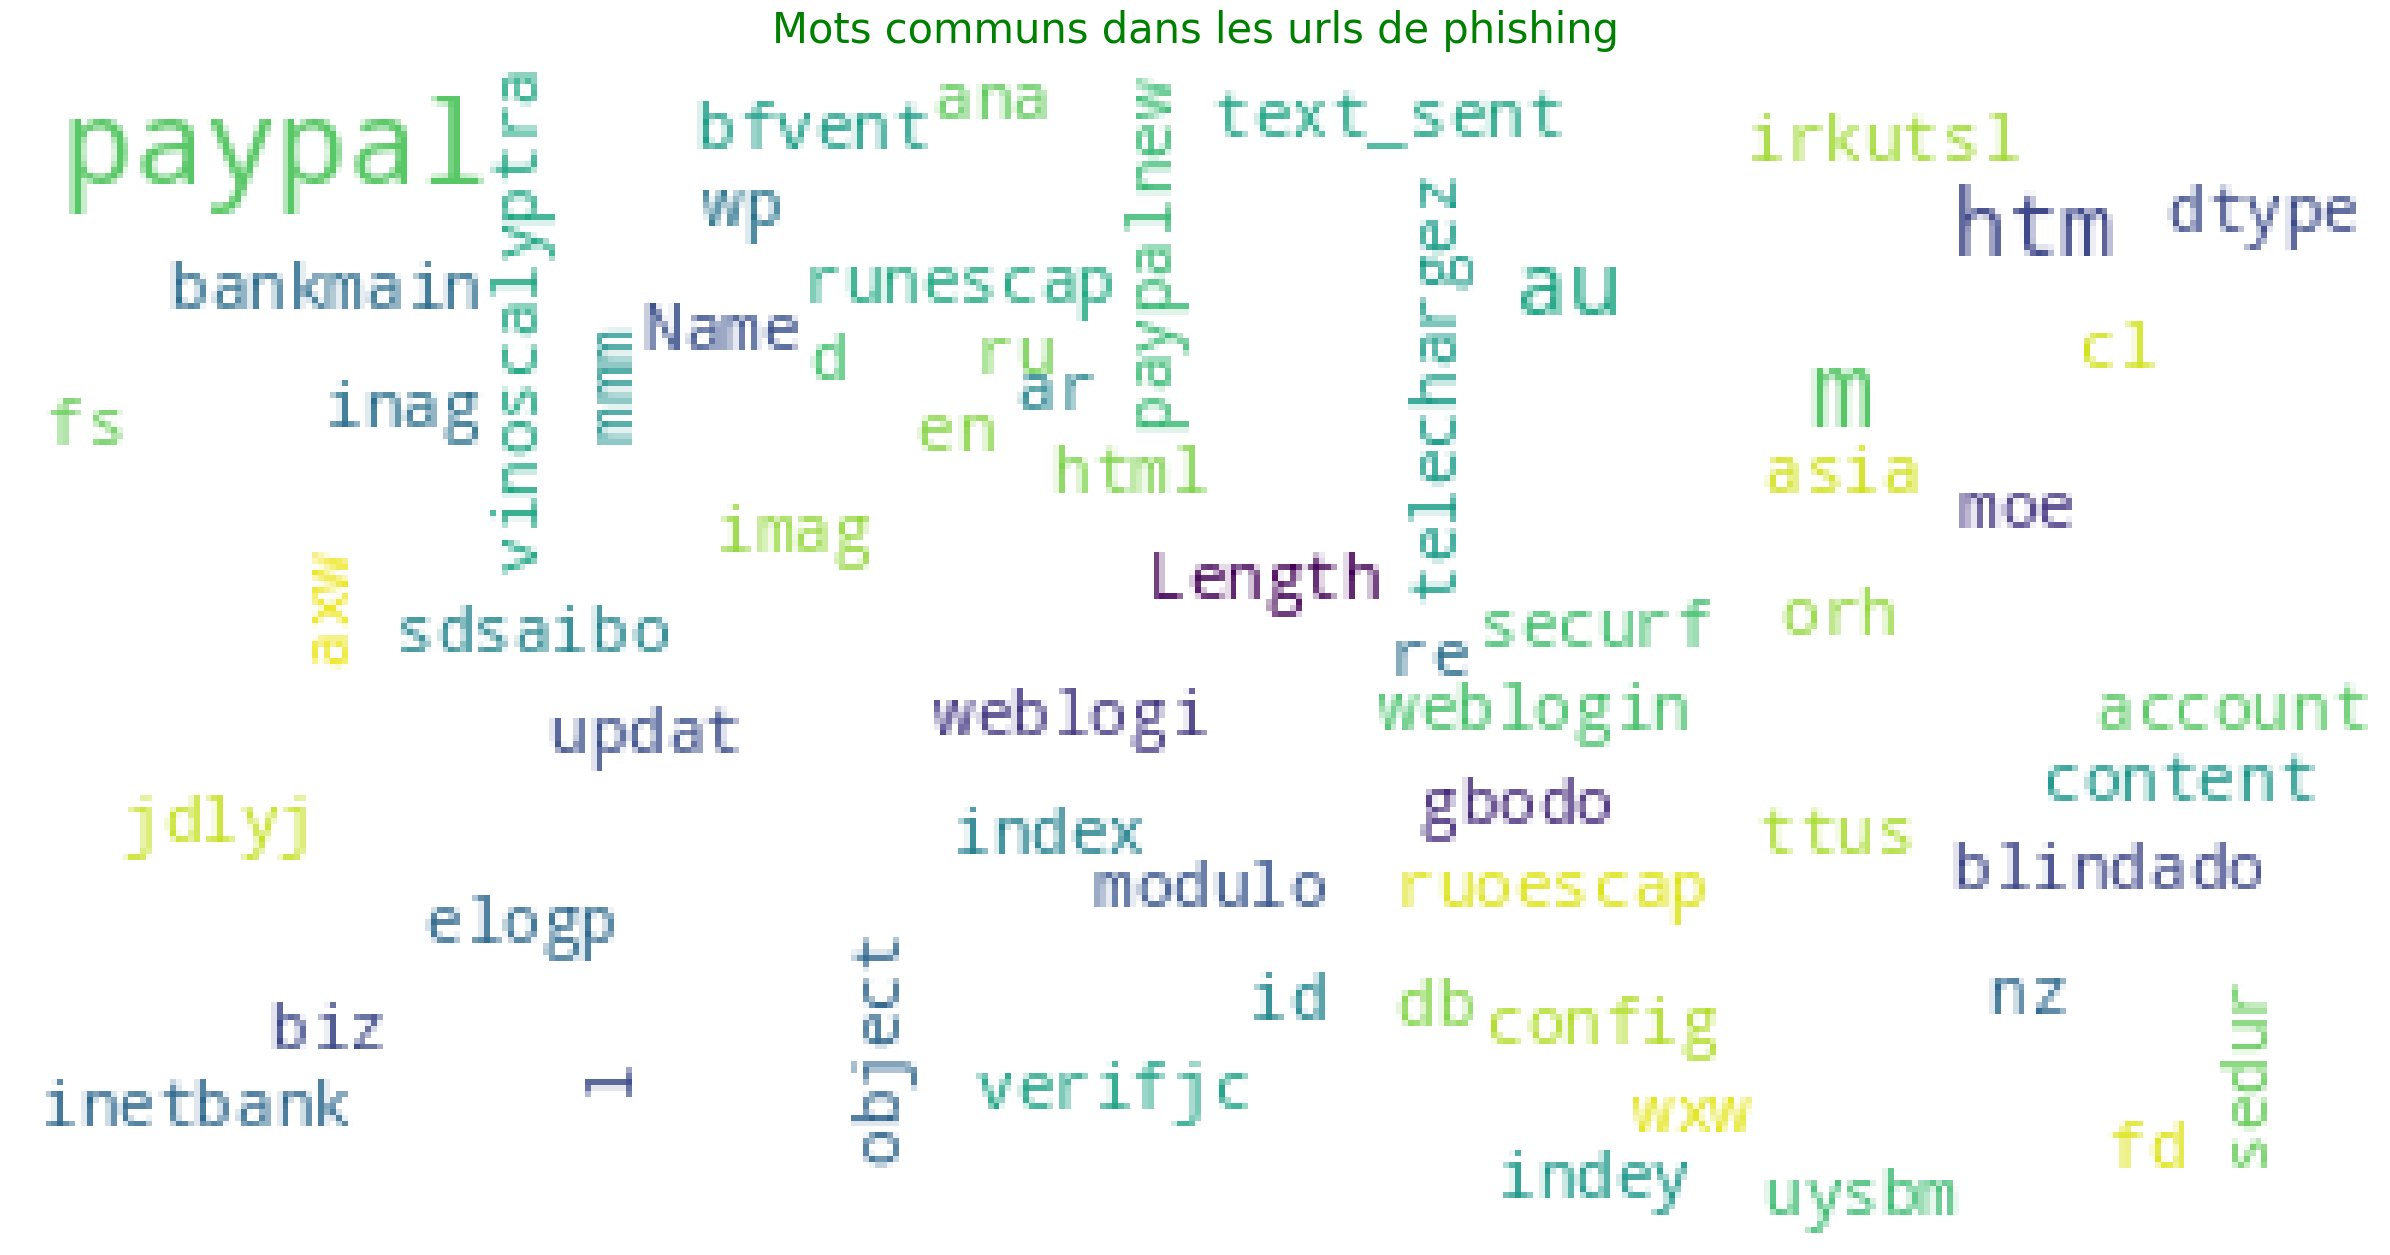

In [ ]:
txt = str(df_Bad.text_sent)
plot_wordcloud(txt, max_words=500, max_font_size=20,
               title = 'Mots communs dans les urls de phishing', title_size=30)

Le nuage de mots ci-dessus montre que les phishers utilisent une variété de termes pour rendre leurs URL attrayantes et crédibles. Les services financiers et les plateformes de paiement comme PayPal sont des cibles fréquentes. L'utilisation de domaines de différents pays et de termes techniques ajoute une couche de complexité, rendant la détection des URL de phishing plus difficile

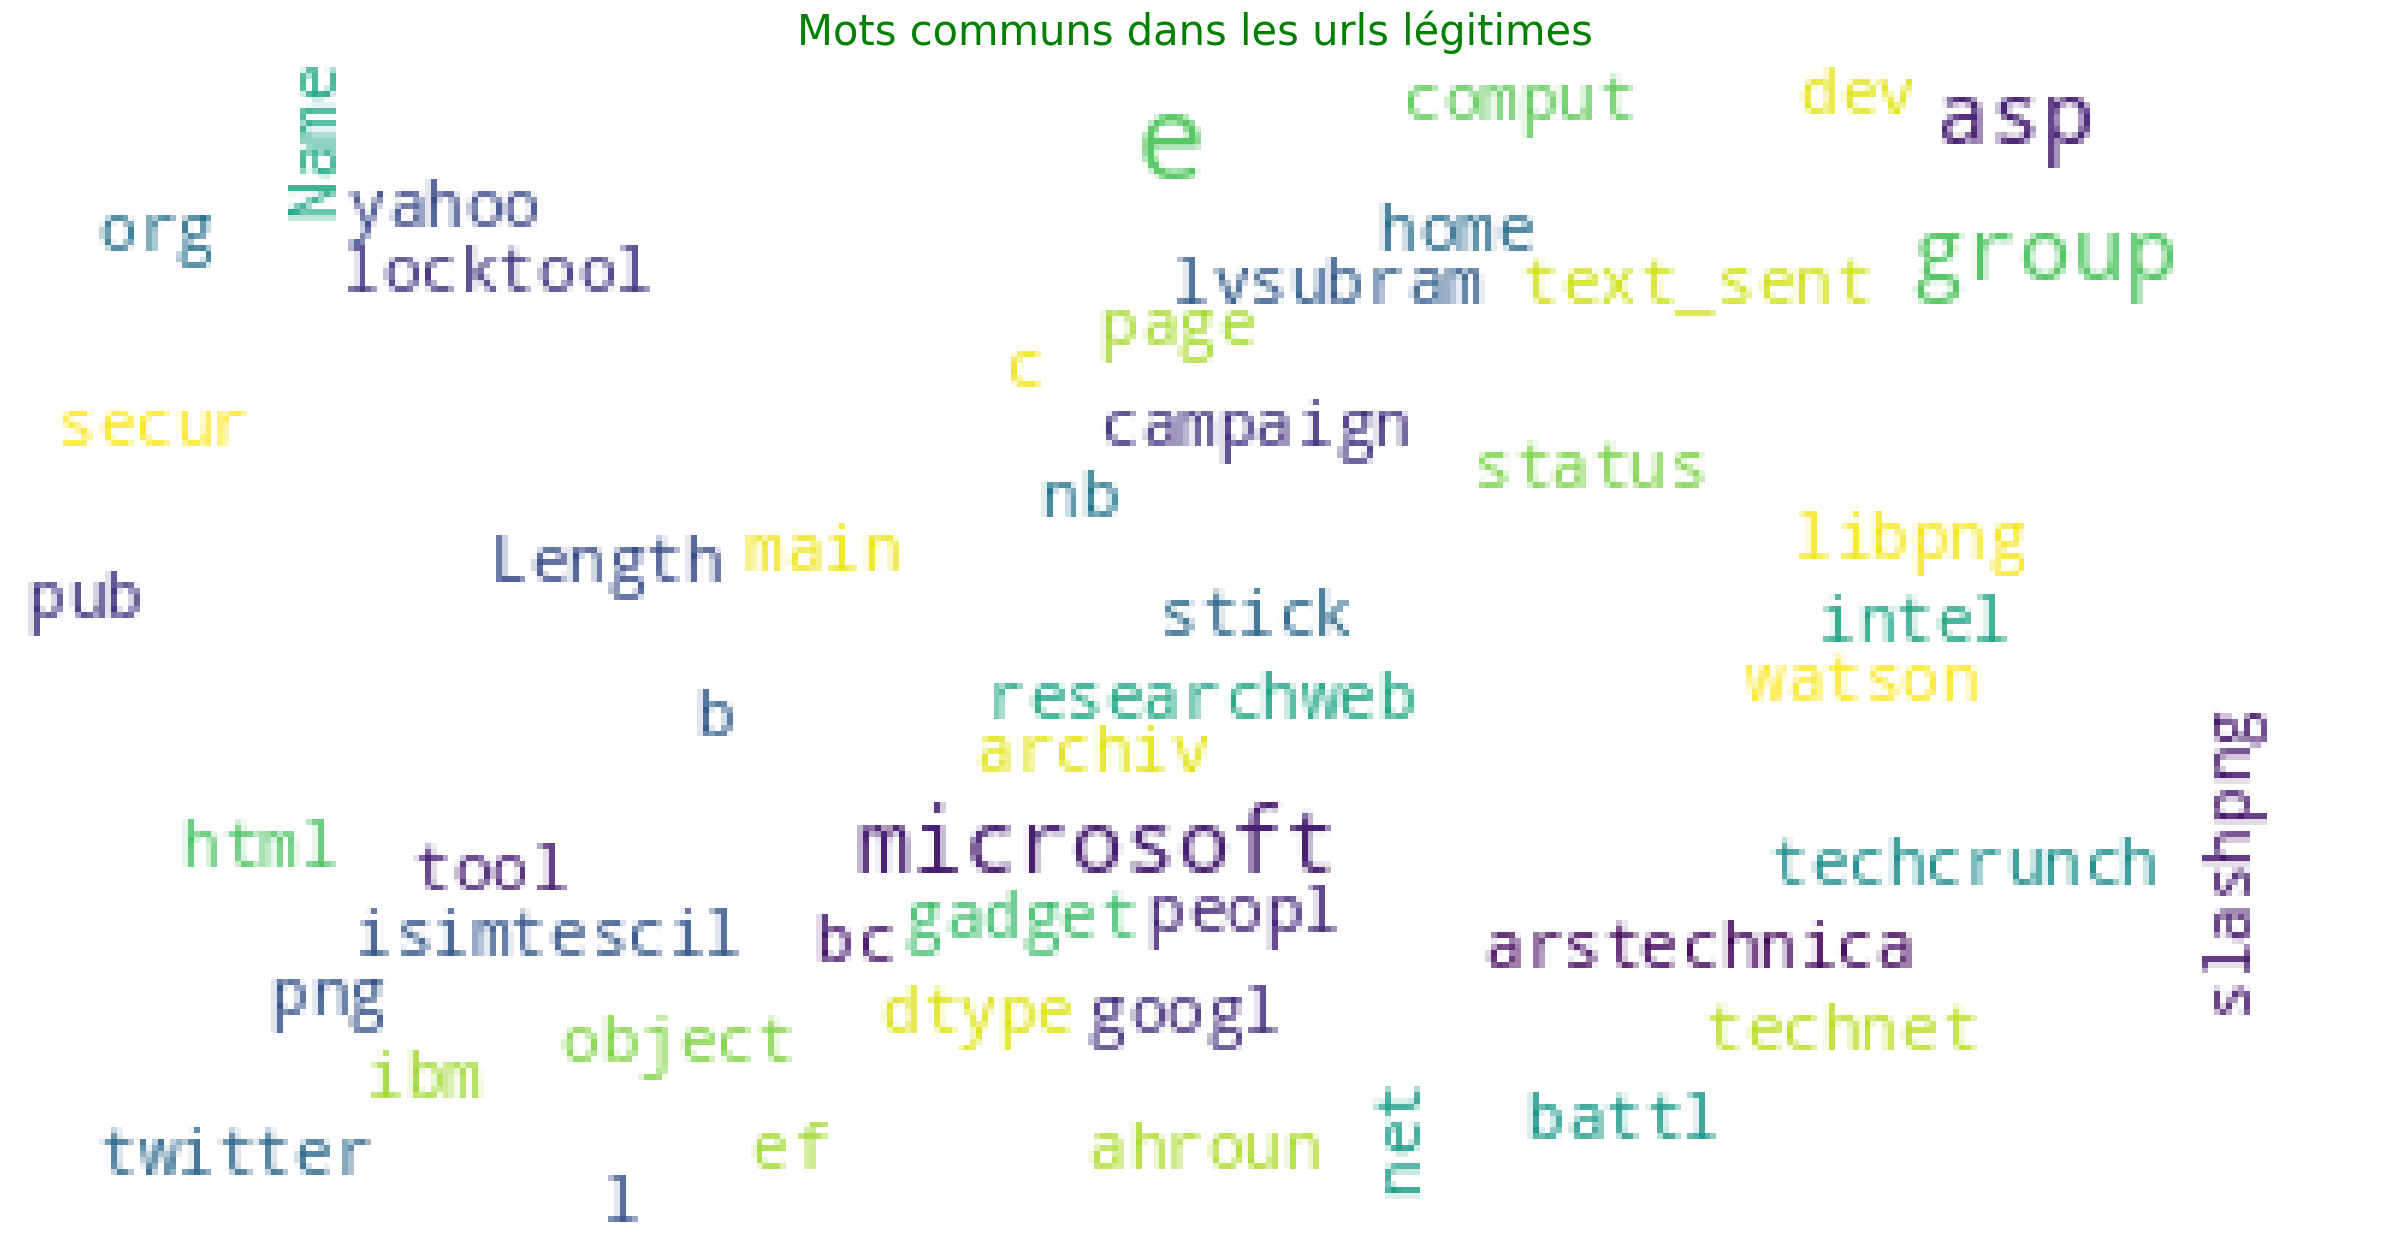

In [ ]:
txt = str(df_Good.text_sent)
plot_wordcloud(txt, max_words=500, max_font_size=20,
               title = 'Mots communs dans les urls légitimes', title_size=30)

Ce nuage de mots montre que les URL légitimes sont souvent associées à des grandes entreprises technologiques bien connues, des termes techniques liés au développement web et des références à des sites de nouvelles technologiques. Contrairement aux URL de phishing, qui utilisent souvent des termes génériques et trompeurs, les URL légitimes ont tendance à être plus spécifiques et à refléter des marques et services établis.

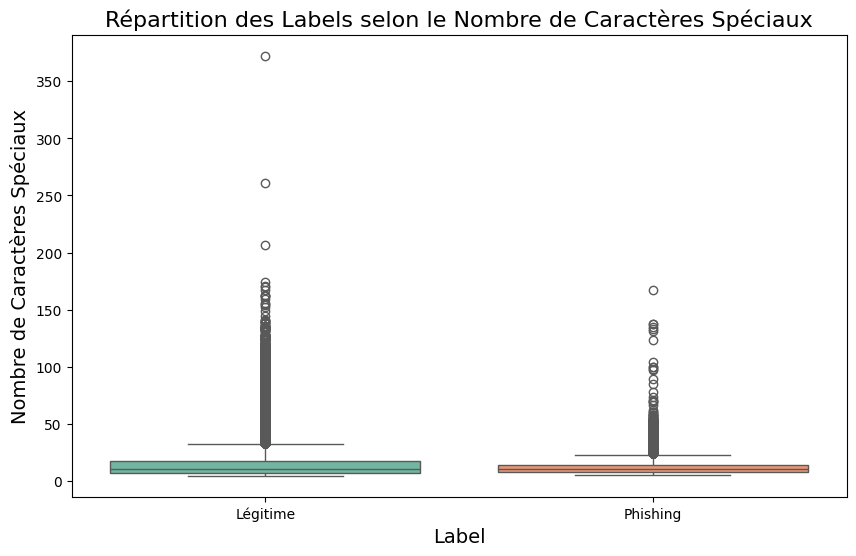

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='label_renamed', y='num_special_chars', data=preprocessed_data, palette='Set2')
plt.title('Répartition des Labels selon le Nombre de Caractères Spéciaux', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Nombre de Caractères Spéciaux', fontsize=14)
plt.show()

Le nombre de caractères spéciaux dans une URL peut être un indicateur intéressant, mais pas suffisant à lui seul pour différencier de manière fiable les URL légitimes des URL de phishing. Les URL légitimes tendent à montrer une plus grande variabilité et une utilisation plus fréquente de caractères spéciaux, tandis que les URL de phishing sont généralement plus uniformes et utilisent moins de caractères spéciaux.

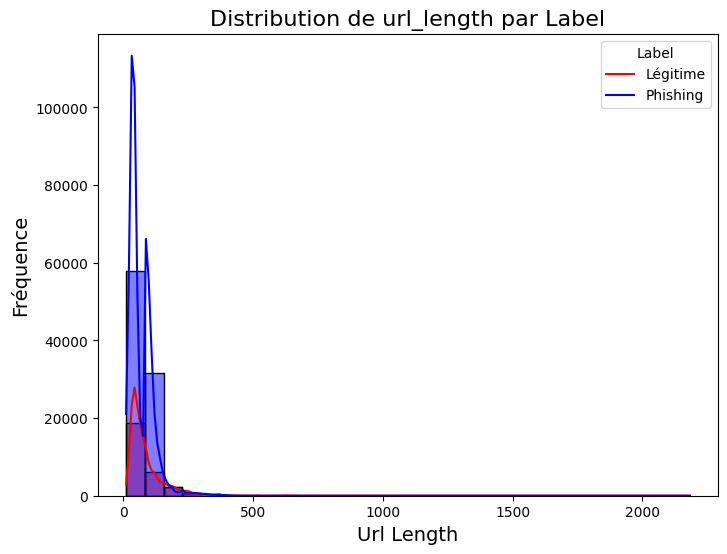

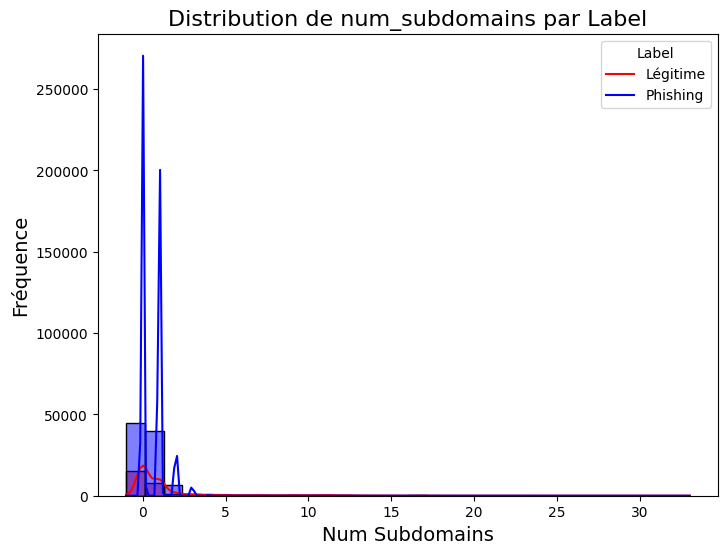

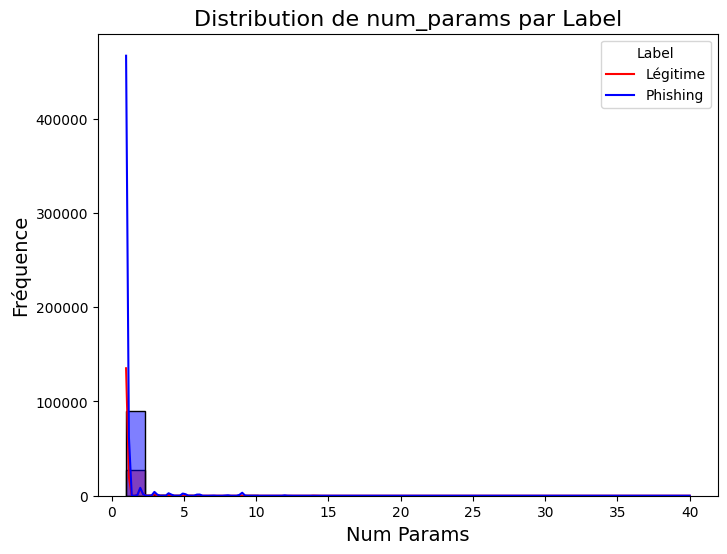

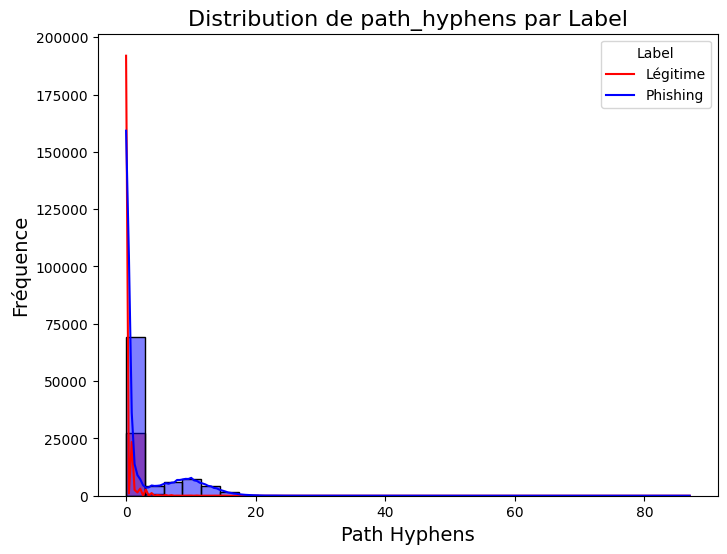

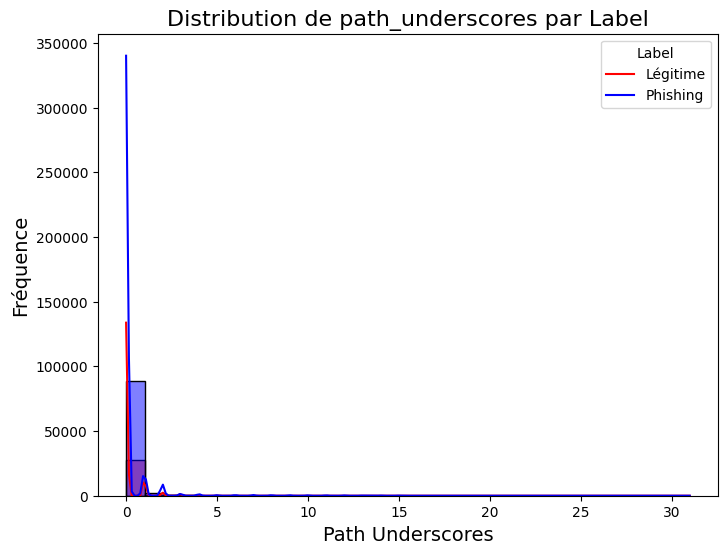

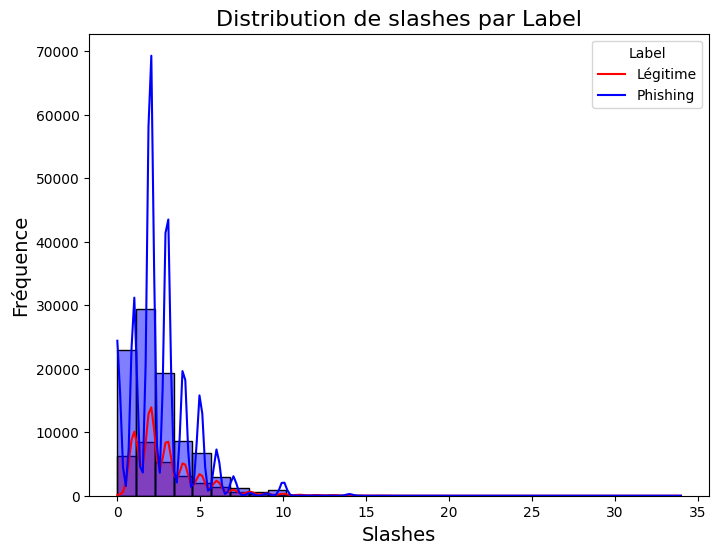

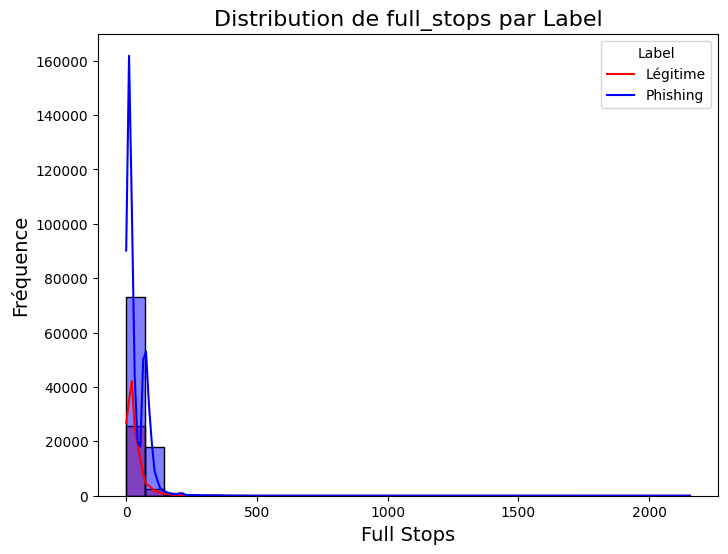

In [ ]:
# Assurez-vous que les labels sont bien nommés
preprocessed_data['label_renamed'] = preprocessed_data['label'].apply(lambda x: 'Légitime' if x == 0.0 else 'Phishing')

# Liste des colonnes à tracer
columns_to_plot = ['url_length', 'num_subdomains', 'num_params', 'path_hyphens', 'path_underscores', 'slashes', 'full_stops']

for column in columns_to_plot:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=preprocessed_data, x=column, hue='label_renamed', bins=30, kde=True, palette={'Légitime': 'blue', 'Phishing': 'red'})
    plt.title(f'Distribution de {column} par Label', fontsize=16)
    plt.xlabel(column.replace('_', ' ').title(), fontsize=14)
    plt.ylabel('Fréquence', fontsize=14)

    # Ajouter une légende
    plt.legend(title='Label', labels=['Légitime', 'Phishing'])

    plt.show()

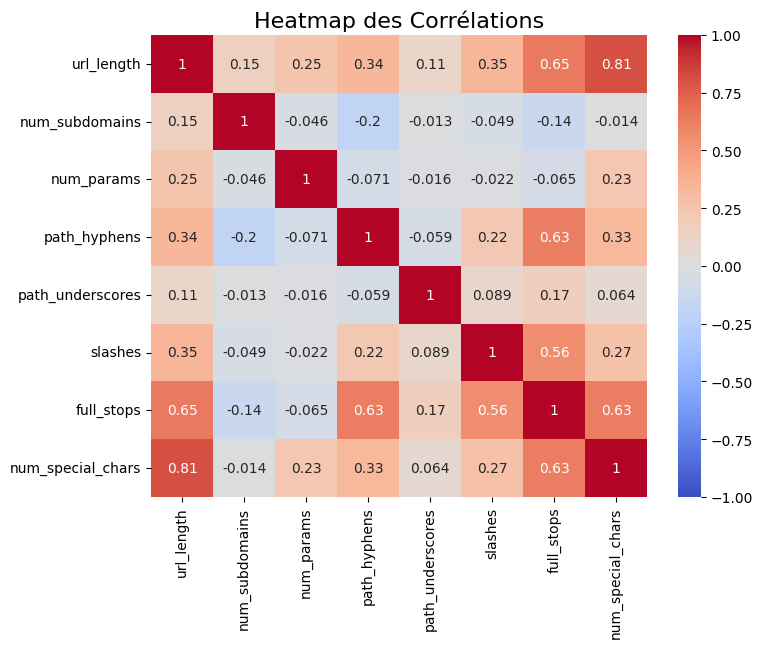

In [ ]:
plt.figure(figsize=(8, 6))
corr = preprocessed_data[['url_length',
       'num_subdomains', 'num_params', 'path_hyphens', 'path_underscores',
       'slashes', 'full_stops', 'num_special_chars']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap des Corrélations', fontsize=16)
plt.show()


Tenant compte de la Heatmap juste au dessus, les features ayant des corrélations élevées peuvent redondantes et potentiellement être réduites ou combinées pour simplifier les modèles. Les faibles corrélations négatives entre certaines caractéristiques suggèrent qu'elles pourraient fournir des informations distinctes utiles pour la classification. Il est donc important de considérer ces corrélations lors de la sélection des caractéristiques pour les modèles de classification afin d'améliorer leur performance et d'éviter les duplications.

J'ai donc sélectionné les features url_length, num_special_chars, num_subdomains, num_params, slashes, path_hyphens, et full_stops permet d'améliorer la performance des modèles en capturant des aspects divers et non redondants des URLs. Cette approche optimise l'utilisation des données pour la classification, améliorant ainsi la précision et la robustesse du modèle de stacking final.

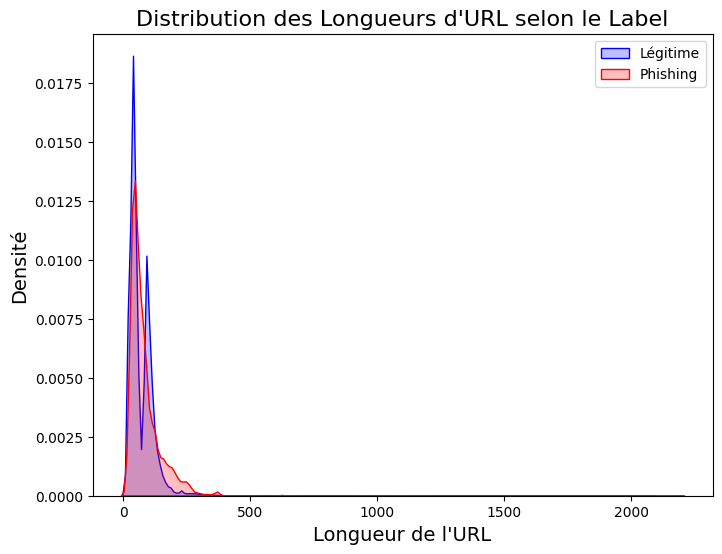

In [ ]:
plt.figure(figsize=(8, 6))
sns.kdeplot(preprocessed_data[preprocessed_data['label'] == 0.0]['url_length'], shade=True, color='blue', label='Légitime')
sns.kdeplot(preprocessed_data[preprocessed_data['label'] == 1.0]['url_length'], shade=True, color='red', label='Phishing')
plt.title('Distribution des Longueurs d\'URL selon le Label', fontsize=16)
plt.xlabel('Longueur de l\'URL', fontsize=14)
plt.ylabel('Densité', fontsize=14)
plt.legend()
plt.show()


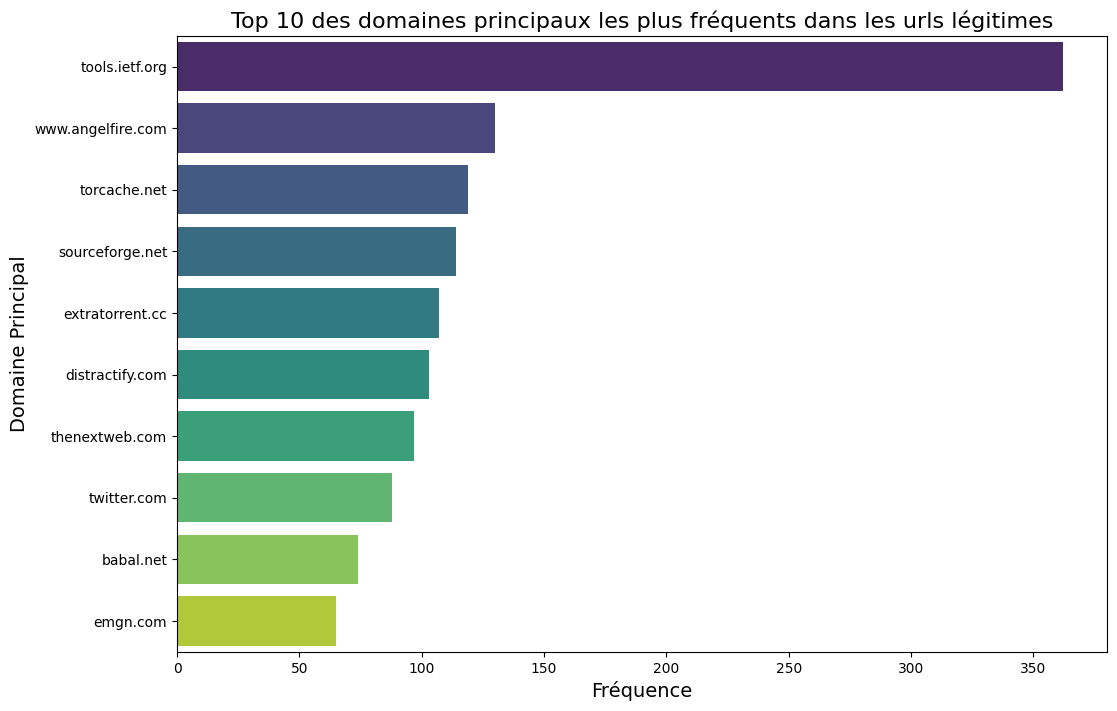

In [ ]:
plt.figure(figsize=(12, 8))
top_domains = df_Good['domain_main'].value_counts().nlargest(10).index
sns.countplot(y='domain_main', data=df_Good[df_Good['domain_main'].isin(top_domains)], order=top_domains, palette='viridis')
plt.title('Top 10 des domaines principaux les plus fréquents dans les urls légitimes', fontsize=16)
plt.xlabel('Fréquence', fontsize=14)
plt.ylabel('Domaine Principal', fontsize=14)
plt.show()

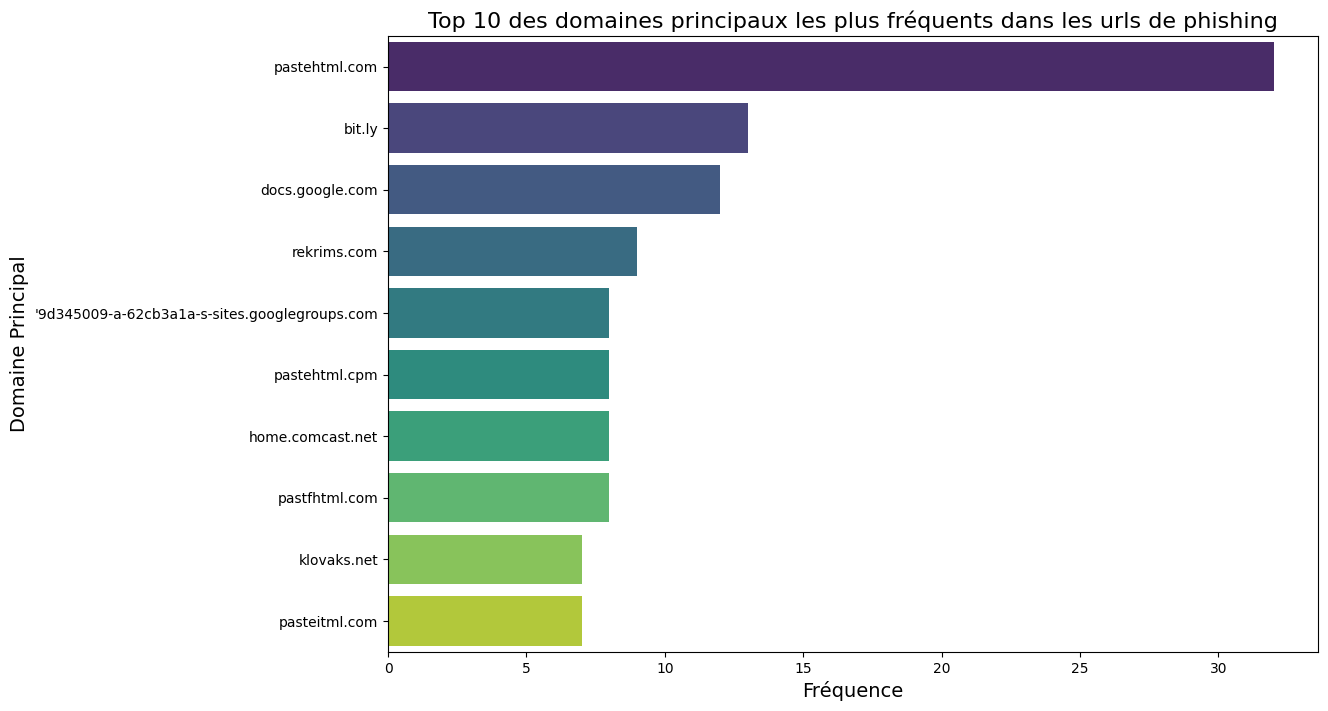

In [ ]:
plt.figure(figsize=(12, 8))
top_domains = df_Bad['domain_main'].value_counts().nlargest(10).index
sns.countplot(y='domain_main', data=df_Bad[df_Bad['domain_main'].isin(top_domains)], order=top_domains, palette='viridis')
plt.title('Top 10 des domaines principaux les plus fréquents dans les urls de phishing', fontsize=16)
plt.xlabel('Fréquence', fontsize=14)
plt.ylabel('Domaine Principal', fontsize=14)
plt.show()

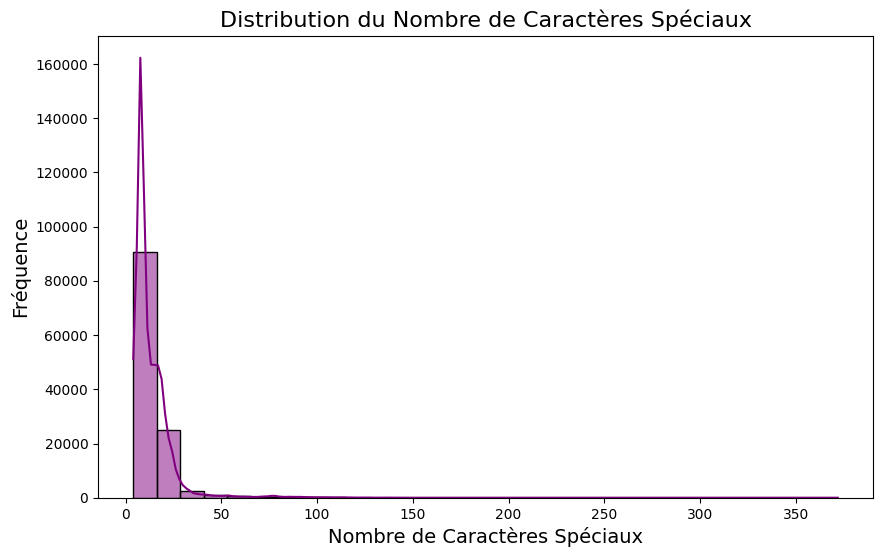

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(preprocessed_data['num_special_chars'], bins=30, kde=True, color='purple')
plt.title('Distribution du Nombre de Caractères Spéciaux', fontsize=16)
plt.xlabel('Nombre de Caractères Spéciaux', fontsize=14)
plt.ylabel('Fréquence', fontsize=14)
plt.show()


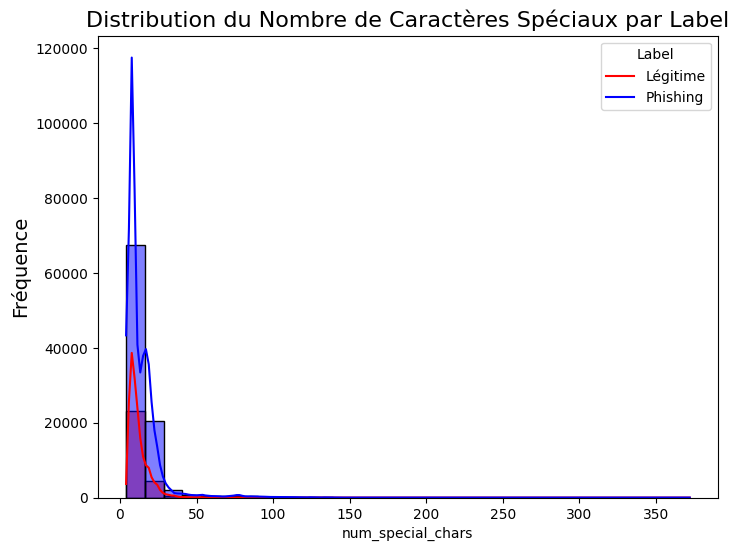

In [ ]:
# Assurez-vous que les labels sont bien nommés
preprocessed_data['label_renamed'] = preprocessed_data['label'].apply(lambda x: 'Légitime' if x == 0.0 else 'Phishing')

plt.figure(figsize=(8,6 ))
sns.histplot(data=preprocessed_data, x='num_special_chars', hue='label_renamed', bins=30, kde=True, palette={'Légitime': 'blue', 'Phishing': 'red'})
plt.title('Distribution du Nombre de Caractères Spéciaux par Label', fontsize=16)
plt.ylabel('Nombre de Caractères Spéciaux', fontsize=14)
plt.ylabel('Fréquence', fontsize=14)

# Ajouter une légende
plt.legend(title='Label', labels=['Légitime', 'Phishing'])

plt.show()

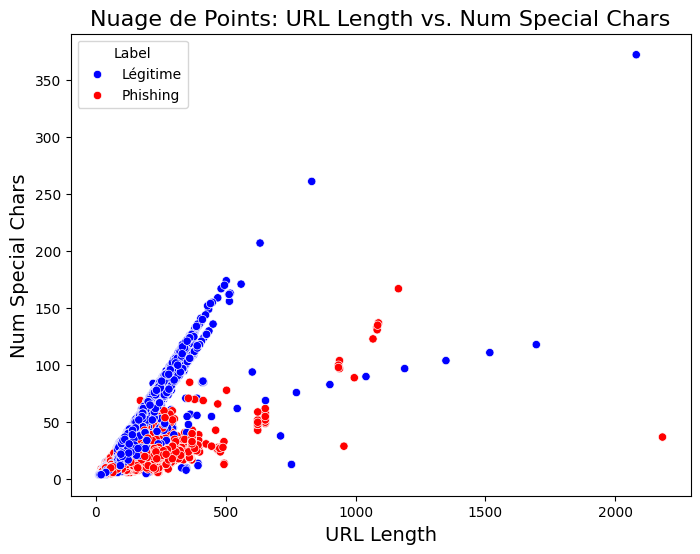

In [ ]:
# Exemple avec deux colonnes, 'url_length' et 'num_special_chars'
plt.figure(figsize=(8, 6))
sns.scatterplot(data=preprocessed_data, x='url_length', y='num_special_chars', hue='label_renamed', palette={'Légitime': 'blue', 'Phishing': 'red'})
plt.title('Nuage de Points: URL Length vs. Num Special Chars', fontsize=16)
plt.xlabel('URL Length', fontsize=14)
plt.ylabel('Num Special Chars', fontsize=14)
plt.legend(title='Label')
plt.show()


# Augmentation des données

Lorsqu'on utilise des pipelines et des vectoriseurs, on a besoin d'un convertisseur pour alimenter le vectoriseur avec chaque mot de cette colonne. Il ne peut pas ajouter les valeurs une ligne à la fois et la classe converter est donc créée.

In [5]:
# Définir les transformateurs personnalisés
class Converter(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.ravel()

In [6]:
# Remplacer les NaN dans les colonnes de texte par des chaînes vides
preprocessed_data['text_sent'].fillna('', inplace=True)
preprocessed_data['domain_main'].fillna('', inplace=True)
preprocessed_data['query'].fillna('', inplace=True)

In [45]:
# Séparer les caractéristiques (X) et les labels (y)
X = preprocessed_data.drop('label', axis=1)
y = preprocessed_data['label']

In [46]:
# Définir les transformateurs pour les colonnes numériques, catégorielles et de texte
num_features = ['url_length', 'num_subdomains', 'num_params', 'path_hyphens', 'slashes', 'full_stops', 'num_special_chars']
numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])

categorical_features = ['tld']
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

vectorizer_transformer = Pipeline(steps=[('con', Converter()), ('tf', TfidfVectorizer())])

In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, categorical_features),
        ('domvec', vectorizer_transformer, 'domain_main'),
        ('sentvec', vectorizer_transformer, 'text_sent'),
        ('queryvec', vectorizer_transformer, 'query')
    ])

In [10]:
# Appliquer les transformations aux caractéristiques
X_transformed = preprocessor.fit_transform(X)

In [11]:
# Appliquer SMOTE pour équilibrer les classes
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_transformed, y)

In [12]:
# Créer un DataFrame sparse équilibré
if scipy.sparse.issparse(X_smote):
    balanced_df = pd.DataFrame.sparse.from_spmatrix(X_smote)
else:
    balanced_df = pd.DataFrame(X_smote)

balanced_df['label'] = y_smote

In [20]:
balanced_df

,0,1,2,3,4,5,6,7,8,9,...,196735,196736,196737,196738,196739,196740,196741,196742,196743,label
0,0.043298,0.029412,0.000000,0.000000,0.096774,0.117647,0.029221,0.032609,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.015200,0.088235,0.000000,0.000000,0.000000,0.088235,0.006957,0.016304,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.055274,0.029412,0.000000,0.114943,0.000000,0.117647,0.054731,0.038043,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.022110,0.058824,0.000000,0.000000,0.000000,0.176471,0.018089,0.019022,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.020267,0.058824,0.000000,0.011494,0.032258,0.088235,0.014378,0.019022,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185355,0.026453,0.029412,0.000000,0.000000,0.000000,0.098957,0.019636,0.015314,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
185356,0.013864,0.058824,0.000000,0.000000,0.000000,0.083827,0.007583,0.010870,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
185357,0.015139,0.029412,0.000000,0.003870,0.000000,0.068727,0.011534,0.008180,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
185358,0.022914,0.029412,0.000000,0.009971,0.000000,0.113748,0.017569,0.015584,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [21]:
# Sauvegarder le DataFrame prétraité
# balanced_df.to_csv('balanced_df.csv', index=False)

In [22]:
# Afficher le nouveau DataFrame équilibré
print(balanced_df['label'].value_counts())
print(balanced_df.head())

label
0.0    92680
1.0    92680
Name: count, dtype: int64
          0         1    2         3         4         5         6         7  \
0  0.043298  0.029412  0.0  0.000000  0.096774  0.117647  0.029221  0.032609   
1  0.015200  0.088235  0.0  0.000000  0.000000  0.088235  0.006957  0.016304   
2  0.055274  0.029412  0.0  0.114943  0.000000  0.117647  0.054731  0.038043   
3  0.022110  0.058824  0.0  0.000000  0.000000  0.176471  0.018089  0.019022   
4  0.020267  0.058824  0.0  0.011494  0.032258  0.088235  0.014378  0.019022   

     8    9  ...  196735  196736  196737  196738  196739  196740  196741  \
0  0.0  0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1  0.0  0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2  0.0  0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3  0.0  0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4  0.0  0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   1

#Implémentation des modèles et entrainement

Pour la classification des URL, j'ai choisi une diversité de modèles afin de maximiser la performance et d'obtenir une comparaison robuste. Les modèles sélectionnés sont : la régression logistique, Random Forest(la forêt aléatoire), le gradient boosting, la machine à vecteurs de support (SVM), XGBoost et le Naive Bayes multinomial.

La régression logistique a été choisie pour sa simplicité et son interprétabilité. Elle offre une base de référence solide grâce à son efficacité pour les tâches de classification binaire.

Le Random Forest est sélectionnée pour sa robustesse contre l'overfitting, en agrégeant plusieurs arbres de décision, et sa capacité à indiquer l'importance des features, ce qui est crucial pour comprendre les variables influentes.

Le gradient boosting est inclus en raison de sa capacité à corriger les biais et les variances par le biais de l'agrégation de modèles faibles. Il est réputé pour sa haute précision et sa flexibilité grâce à ses hyperparamètres ajustables.

La SVM est choisie pour sa création de marges maximales efficaces et sa robustesse dans la classification binaire, ce qui aide à réduire l'overfitting grâce à l'utilisation de fonctions de noyau appropriées.

XGBoost est retenu pour son optimisation avancée, sa régularisation améliorée, et sa performance supérieure, en particulier sur les grands jeux de données.

Enfin, le Naive Bayes multinomial est inclus pour sa simplicité et son efficacité dans la classification de texte, ce qui le rend pertinent pour les données textuelles dérivées des URL.

Les méthodes que j'ai choisi permettent une comparaison diversifiée, couvrant les modèles d'arbres, linéaires et probabilistiques. Cela m'assure que je peux sélectionner les meilleurs modèles pour le stacking, en optimisant les performances globales.

In [ ]:
preprocessed_data.columns

Index(['domain', 'label', 'text_tokenized', 'text_stemmed', 'text_sent',
       'parsed_url', 'domain_main', 'path', 'query', 'tld', 'url_length',
       'num_subdomains', 'num_params', 'path_hyphens', 'path_underscores',
       'slashes', 'full_stops', 'num_special_chars'],
      dtype='object')

Les données résultant de l'augmentation sont trop volumineuses et consomment beaucoup de ressources en terme de RAM pour l'entraînement des modèles. Par conséquent, exceptionnellement pour ce test, je ne vais pas utiliser ces données car je ne dispose pas des ressources nécessaires. Néanmoins, même sans augmentation des données, les résultats des algorithmes sont assez convaincants.

In [29]:
#Lors de l'utilisation de données augmentées

# df_y = balanced_df['label']
# df_x = balanced_df.drop('label', axis=1)

In [21]:
df_y = preprocessed_data['label']
df_x = preprocessed_data.drop('label', axis=1)

In [22]:
df_x.head()

,domain,text_tokenized,text_stemmed,text_sent,parsed_url,domain_main,path,query,tld,url_length,num_subdomains,num_params,path_hyphens,path_underscores,slashes,full_stops,num_special_chars
0,http://sprint.com/business/solutions/mobility_...,"['http', 'sprint', 'com', 'business', 'solutio...","['http', 'sprint', 'com', 'busi', 'solut', 'mo...",http sprint com busi solut mobil secur and man...,"ParseResult(scheme='http', netloc='sprint.com'...",sprint.com,/business/solutions/mobility_security_and_mana...,intnav=atg:he:mobsecmgmt,com,105,0,1,0,3,4,63,16
1,http://hesperia.gsfc.nasa.gov/~schmahl/nnls/,"['hesperia', 'gsfc', 'nasa', 'gov', 'schmahl',...","['hesperia', 'gsfc', 'nasa', 'gov', 'schmahl',...",hesperia gsfc nasa gov schmahl nnls,"ParseResult(scheme='http', netloc='hesperia.gs...",hesperia.gsfc.nasa.gov,/~schmahl/nnls/,,gov,44,2,1,0,0,3,15,10
2,http://web.de/magazine/digital/sicher-im-netz/...,"['http', 'web', 'de', 'magazine', 'digital', '...","['http', 'web', 'de', 'magazin', 'digit', 'sic...",http web de magazin digit sicher im netz siche...,"ParseResult(scheme='http', netloc='web.de', pa...",web.de,/magazine/digital/sicher-im-netz/sicherheitshi...,,de,131,0,1,10,0,4,118,18
3,http://www.wired.com/science/discoveries/news/...,"['www', 'wired', 'com', 'science', 'discoverie...","['www', 'wire', 'com', 'scienc', 'discoveri', ...",www wire com scienc discoveri news,"ParseResult(scheme='http', netloc='www.wired.c...",www.wired.com,/science/discoveries/news/1999/08/21495,,com,59,1,1,0,0,6,39,11
4,http://thomas.arnatt.com/wp-includes/pono/aol_...,"['thomas', 'arnatt', 'com', 'wp', 'includes', ...","['thoma', 'arnatt', 'com', 'wp', 'includ', 'po...",thoma arnatt com wp includ pono aol logio htm,"ParseResult(scheme='http', netloc='thomas.arna...",thomas.arnatt.com,/wp-includes/pono/aol_logio.htm,,com,55,1,1,1,1,3,31,11


In [23]:
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2)

In [24]:
class Converter(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, data_frame):
        return data_frame.values.ravel()

Les features numériques ont besoin de leur propre pipeline pour mettre à l'échelle les données, MinMaxScaler a été utilisé car MultinomialNB n'accepte pas de valeurs négatives.

In [47]:
num_features = ['url_length','num_subdomains', 'num_params','path_hyphens','slashes',
                'full_stops', 'num_special_chars']
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

In [26]:
categorical_features = ['tld']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [27]:
vectorizer_features = ['text_sent','domain_main', 'query']
vectorizer_transformer = Pipeline(steps=[
    ('con', Converter()),
    ('tf', TfidfVectorizer())])

In [28]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, categorical_features),
        ('domvec', vectorizer_transformer, ['domain_main']),
        ('sentvec', vectorizer_transformer, ['text_sent']),
        ('queryvec', vectorizer_transformer, ['query'])
            ])

svc_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LinearSVC())])

log_reg_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

nb_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', MultinomialNB())])

rand_for_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])

grad_b_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', GradientBoostingClassifier(n_estimators=100, random_state=42))])

xgd_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'))])

In [17]:
#Lors de l'utilisation de données augmentées

# # Modèle SVM
# svc_clf = LinearSVC()

# # Modèle de Régression Logistique
# log_reg_clf = LogisticRegression()

# # Modèle de Naive Bayes
# nb_clf = MultinomialNB()

# # Modèle Random Forest
# rand_for_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# # Modèle Gradient Boosting
# grad_b_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)

# # Modèle XGBoost
# xgd_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

In [30]:
svc_clf.fit(X_train, y_train)
log_reg_clf.fit(X_train, y_train)
nb_clf.fit(X_train, y_train)
rand_for_clf.fit(X_train, y_train)
grad_b_clf.fit(X_train, y_train)
xgd_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['url_length',
                                                   'num_subdomains',
                                                   'num_params', 'path_hyphens',
                                                   'path_underscores',
                                                   'slashes', 'full_stops',
                                                   'num_special_chars']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['tld']),
                                                 ('domvec',
                                                  Pipeline(steps=[('...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

Les critères d'évaluation utilisés sont l'accuracy, la precision, le recall et le F1-score, chacun apportant une perspective différente sur la performance des modèles. En combinant ces modèles variés et ces mesures d'évaluation, nous visons une robustesse et une généralisation optimales pour la classification des URL légitimes et de phishing.

Petit rappel sur les métriques d'évaluation;

1. **Accuracy (Précision Globale)** : La proportion de prédictions correctes parmi l'ensemble des prédictions. C'est une mesure générale de la performance du modèle.

2. **Precision (Précision)** : Le ratio des vraies positives sur l'ensemble des prédictions positives. Cela indique la qualité des prédictions positives du modèle.

3. **Recall (Rappel)** : Le ratio des vraies positives sur l'ensemble des instances positives réelles. Cette métrique mesure la capacité du modèle à identifier toutes les instances positives.

4. **F1-Score** : La moyenne harmonique de la précision et du rappel. Il équilibre les deux métriques et est utile lorsque l'on veut un compromis entre précision et rappel, en particulier dans les cas de classes déséquilibrées.

In [31]:
def results(name: str, model: BaseEstimator) -> None:
    preds = model.predict(X_test)

    print(name + " score: %.3f" % model.score(X_test, y_test))
    print(classification_report(y_test, preds))
    labels = ['Légitime', 'Phishing']

    conf_matrix = confusion_matrix(y_test, preds)


    plt.figure(figsize= (8,6))
    sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d", cmap='Greens')
    plt.title("Matrix de Confusion du modele " + name)
    plt.ylabel('Classe Réele')
    plt.xlabel('Classe Prédite')

SVC score: 0.945
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     18588
         1.0       0.98      0.78      0.87      5610

    accuracy                           0.95     24198
   macro avg       0.96      0.89      0.92     24198
weighted avg       0.95      0.95      0.94     24198



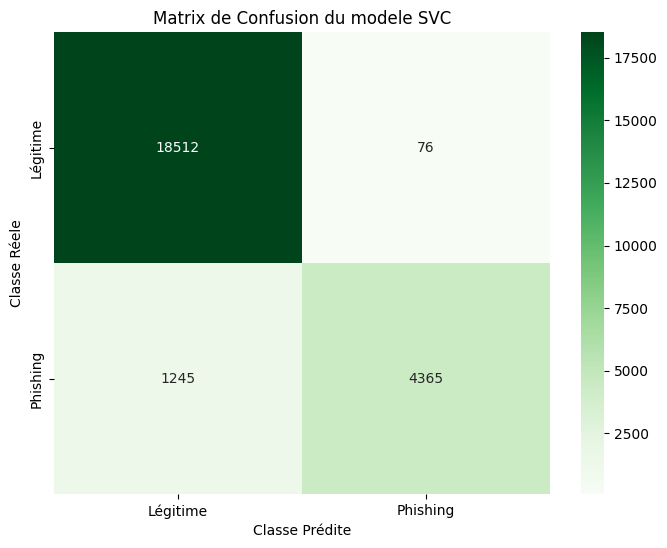

In [32]:
results("SVC" , svc_clf)

Logistic Regression score: 0.941
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     18588
         1.0       0.98      0.76      0.86      5610

    accuracy                           0.94     24198
   macro avg       0.96      0.88      0.91     24198
weighted avg       0.94      0.94      0.94     24198



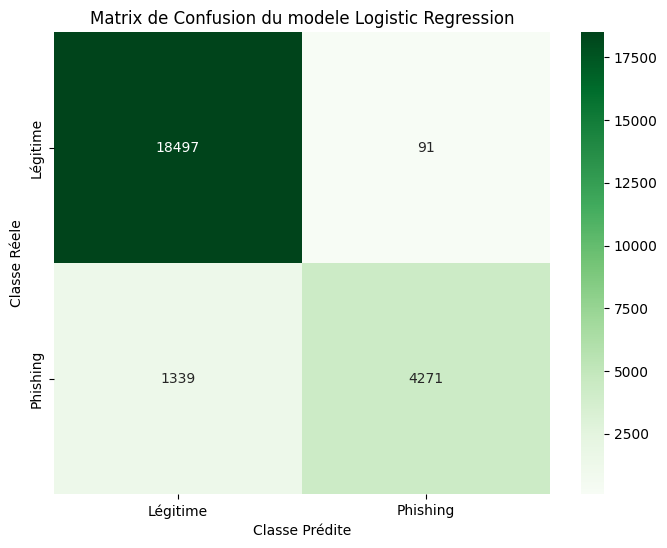

In [33]:
results("Logistic Regression" , log_reg_clf)

Naive Bayes score: 0.950
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     18588
         1.0       0.96      0.82      0.88      5610

    accuracy                           0.95     24198
   macro avg       0.95      0.90      0.93     24198
weighted avg       0.95      0.95      0.95     24198



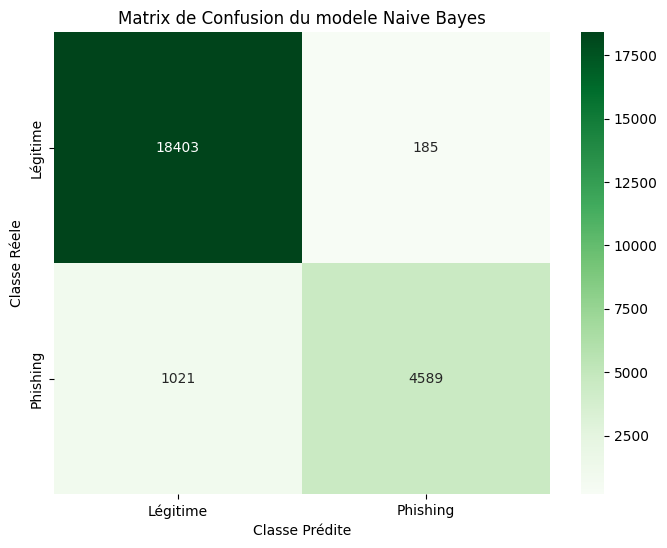

In [34]:
results("Naive Bayes" , nb_clf)

Random Forest score: 0.977
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99     18588
         1.0       0.99      0.91      0.95      5610

    accuracy                           0.98     24198
   macro avg       0.98      0.95      0.97     24198
weighted avg       0.98      0.98      0.98     24198



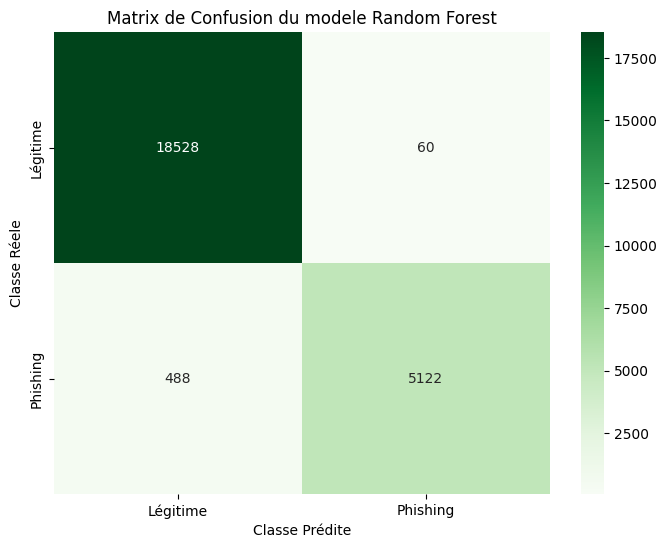

In [35]:
results("Random Forest" , rand_for_clf)

Gradient Boosting score: 0.953
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     18588
         1.0       0.95      0.84      0.89      5610

    accuracy                           0.95     24198
   macro avg       0.95      0.91      0.93     24198
weighted avg       0.95      0.95      0.95     24198



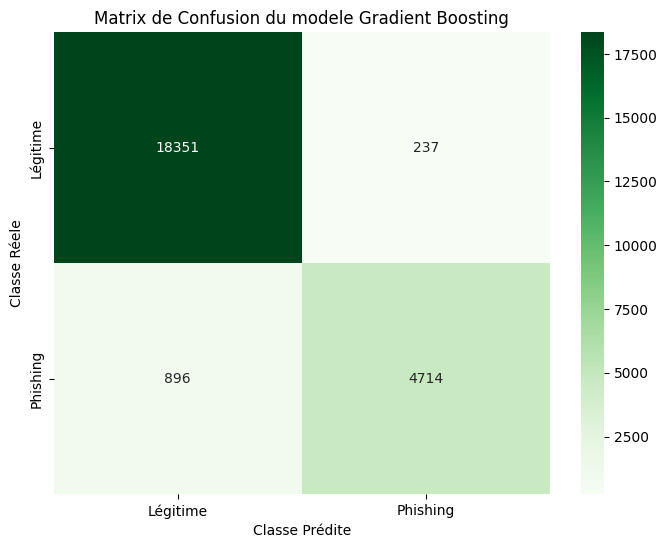

In [36]:
results("Gradient Boosting" , grad_b_clf)

XG Boosting score: 0.966
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98     18588
         1.0       0.98      0.87      0.92      5610

    accuracy                           0.97     24198
   macro avg       0.97      0.93      0.95     24198
weighted avg       0.97      0.97      0.97     24198



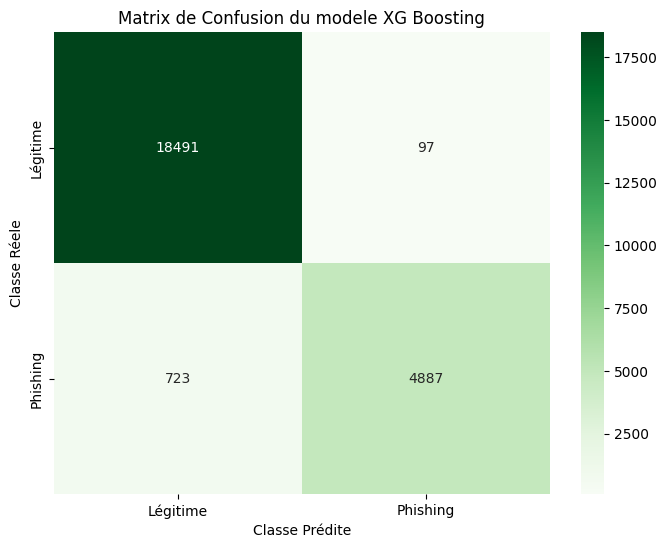

In [37]:
results("XG Boosting" , xgd_clf)

In [38]:
models = {
    "Support Vector Machine": svc_clf,
    "Logistic Regression": log_reg_clf,
    "Multinomial Naive Bayes": nb_clf,
    "Random Forest": rand_for_clf,
    "Gradient Boosting": grad_b_clf,
    "XGBoost": xgd_clf
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"{name} - Accuracy: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))


Support Vector Machine - Accuracy: 0.9454087114637574
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     18588
         1.0       0.98      0.78      0.87      5610

    accuracy                           0.95     24198
   macro avg       0.96      0.89      0.92     24198
weighted avg       0.95      0.95      0.94     24198

Logistic Regression - Accuracy: 0.9409042069592528
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     18588
         1.0       0.98      0.76      0.86      5610

    accuracy                           0.94     24198
   macro avg       0.96      0.88      0.91     24198
weighted avg       0.94      0.94      0.94     24198

Multinomial Naive Bayes - Accuracy: 0.9501611703446566
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     18588
         1.0       0.96      0.82      0.88      5610

    accuracy          

# Sélection des Modèles et Implémentation du Stacking

À partir des résultats obtenus, les trois meilleurs modèles en termes de précision sont :

Random Forest en raison de son meilleur score global en accuracy (0.9773), recall (0.95), et F1-Score (0.97), indiquant une très bonne capacité à détecter les instances positives (phishing) et une balance optimale entre précision et rappel.

XGBoost en raison de son excellente accuracy  de 0.9661, haute précision (0.93), et un F1-Score élevé (0.95), montrant une performance robuste et équilibrée.

Gradient Boosting, comme les 2 precedent, d'abord en raison de sa bonne accuracy de 0.9531, recall  de 0.91, et son F1-Score à 0.93, démontrant une capacité significative à corriger les erreurs de biais et variance, offrant une haute précision et une bonne balance entre les métriques. J'ai égualement retenue Gradient Boosting pour sa capacité à améliorer la précision tout en maintenant un bon rappel, ce qui en fait un excellent choix pour améliorer les prédictions via le stacking.

In [39]:
# Create a StackingClassifier with the selected models
stacking_clf = StackingClassifier(
    estimators=[
        ('random_forest', rand_for_clf),
        ('xgboost', xgd_clf),
        ('gradient_boosting', grad_b_clf)
    ],
    final_estimator=LogisticRegression(),
    cv=5
)

# Fit the StackingClassifier on the training data
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('random_forest',
                                Pipeline(steps=[('preprocessor',
                                                 ColumnTransformer(transformers=[('num',
                                                                                  Pipeline(steps=[('scaler',
                                                                                                   MinMaxScaler())]),
                                                                                  ['url_length',
                                                                                   'num_subdomains',
                                                                                   'num_params',
                                                                                   'path_hyphens',
                                                                                   'path_underscores',
                                                                                   'slashes',
                                                                                   'full_stops',
                                                                                   'num_special_chars']),
                                                                                 ('cat',
                                                                                  Pipeline(steps=[('onehot',
                                                                                                   OneHotEncoder(handle_unkno...
                                                                                  Pipeline(steps=[('con',
                                                                                                   Converter()),
                                                                                                  ('tf',
                                                                                                   TfidfVectorizer())]),
                                                                                  ['domain_main']),
                                                                                 ('sentvec',
                                                                                  Pipeline(steps=[('con',
                                                                                                   Converter()),
                                                                                                  ('tf',
                                                                                                   TfidfVectorizer())]),
                                                                                  ['text_sent']),
                                                                                 ('queryvec',
                                                                                  Pipeline(steps=[('con',
                                                                                                   Converter()),
                                                                                                  ('tf',
                                                                                                   TfidfVectorizer())]),
                                                                                  ['query'])])),
                                                ('classifier',
                                                 GradientBoostingClassifier(random_state=42))]))],
                   final_estimator=LogisticRegression())

Stacking Classifier score: 0.985
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     18588
         1.0       0.97      0.96      0.97      5610

    accuracy                           0.99     24198
   macro avg       0.98      0.98      0.98     24198
weighted avg       0.99      0.99      0.99     24198



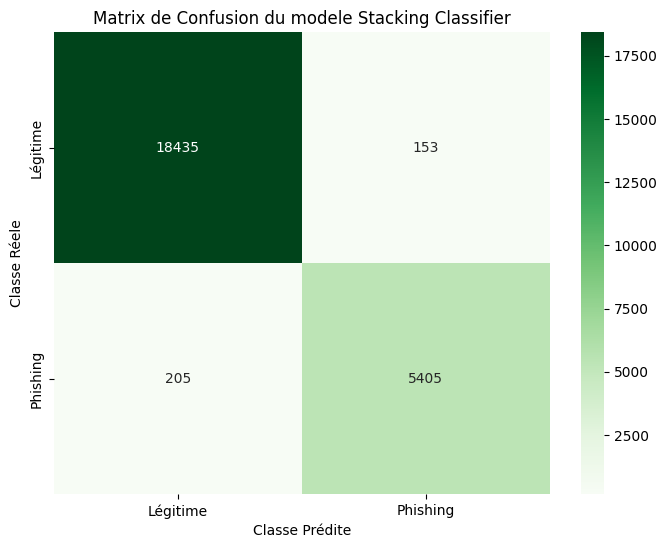

In [40]:
results("Stacking Classifier" , stacking_clf)

Les résultats obtenus pour le modèle de stacking montrent une performance impressionnante, avec un score global de 0.985 en termes de précision. Ce modèle s'avère être plus optimal que les modèles individuels en raison de sa capacité à combiner les forces de chacun et à atténuer leurs faiblesses.

Je trouve particulièrement significatif que les résultats montrent une amélioration notable de toutes les métriques d'évaluation, surtout en termes de rappel et de F1-score pour la classe phishing. Je trouve que cette amélioration est cruciale pour la détection de telles menaces. La robustesse et la capacité de généralisation accrues du modèle de stacking en font un choix supérieur pour cette tâche de classification des URL légitimes et de phishing.

In [41]:
import joblib

#Sauvegarde le modèle de stacking dans un fichier.

def save_stacking_model(model, filename):

    joblib.dump(model, filename)
    print(f"Le modèle de stacking a été sauvegardé dans le fichier: {filename}")

In [42]:
save_stacking_model(stacking_clf, 'stacking_model.pkl')

Le modèle de stacking a été sauvegardé dans le fichier: stacking_model.pkl
